# Stability

This module has only one package: spectral_fraction. This package implements the calculation of spectral fraction as described in Volk & Malhotra 2020.

This is done by simulating a system for $5\times10^6$ orbits of the inner planet, calculating the angular momentum deficit (AMD) for each planet at 3000 equally spaced steps, and computing a power spectra of the AMD using a Fourier transform. The spectral fraction is the number of peaks that have at least 5% of the max power divided by the number of frequencies evaluated.

Per Volk & Malhotra 2020, a spectral fraction above 0.01 corresponded with instability on timescales of $5\times10^9$ orbits.

AMD is calculated for the $j$th planet as:

$$\frac{m_jM_\star}{m_j+M_\star} \sqrt{G(m_j+M_\star)a_j}(1-\text{cos}i_j\sqrt{1-e_j^2})$$

In [1]:
import spectral_fraction

import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
import rebound

#load an example sim, in this case, Kep-18 from a PhoDyMM output
sim = rebound.Simulation('Kep18_best_params.bin')

<div class="alert alert-block alert-warning">
The following 2 cells will take a few minutes to run each.</div>

In [3]:
#sf_AMD_sim
#this function takes a simulation as an input and returns the AMD spectral fraction for each planet
#if returneccs is turned on, it will also return the max ecc seen for each planet

#because this function is performing the 5x10^6 orbit integration, it can be a bit slow!

spec_frac_K18 = spectral_fraction.sf_AMD_sim(sim)

print('spectral fractions:',spec_frac_K18)

spectral fractions: [0.00333333 0.002      0.00333333]


In [4]:
#because this function is performing the 5x10^6 orbit integration, it can be a bit slow!

spec_frac_K18,max_eccs_K18 = spectral_fraction.sf_AMD_sim(sim,returneccs=True)

print('spectral fractions:',spec_frac_K18)
print('max eccs:',max_eccs_K18)

spectral fractions: [0.00333333 0.002      0.00333333]
max eccs: [0.03460407 0.0199281  0.01843031]


In [5]:
#if the simulation is unstable (via collision, ejection, or orbit crossing), will get nan in return
#also will print a reason and the time in the simulation when it was ended

#load an example sim, in this case, Kep-18 but with an error in the mean longitudes
sim_unstable = rebound.Simulation('Kep18_invalid.bin')

spec_frac_K18 = spectral_fraction.sf_AMD_sim(sim_unstable)

print('spectral fractions:',spec_frac_K18)

collision, time 0.03014136597124461
spectral fractions: [nan nan nan]


In [6]:
#sf_AMD_simarch
#if you want to separate the slow integration from the quick spectral fraction calculation
#this function also returns the spectral fractions of each planet
#input is a simulation archive rather than a simulation

#load a previously integrated simulation archive, see next cell for code example
simarch = rebound.SimulationArchive('Kep18_best_params_sa.bin')

spec_frac_K18 = spectral_fraction.sf_AMD_simarch(simarch)

print('spectral fractions:',spec_frac_K18)

spectral fractions: [0.00333333 0.002      0.00333333]


A full example of using SimulationArchive is beyond the scope, but see the `REBOUND`  __[documentation](https://rebound.readthedocs.io/en/latest/simulationarchive/)__ for information and examples.

Generating the SimArch used here was done via the following code:

```
p = sim.particles
sim.integrator = 'WHFast'
#this will be faster but less accurate than the default IAS15, can use any integrator in REBOUND you prefer
sim.dt = p[1].P/50 #50 timesteps in the inner orbit #if using IAS15, not required

t0 =  sim.t
tmax = t0 + 5e6*p[1].P #run for 5 million orbits of inner planet
Nsteps = 3000 #use same number of steps as VM20
intvl = (tmax-t0)/Nsteps #interval to save snapshots in the simulation archive

#this will automatically save to the SA as the integration runs
sim.automateSimulationArchive('Kep18_best_params_sa.bin',interval=intvl,
                              deletefile=True)
sim.integrate(tmax) #this takes on order of a few minutes to integrate typically
```

Text(0, 0.5, 'power')

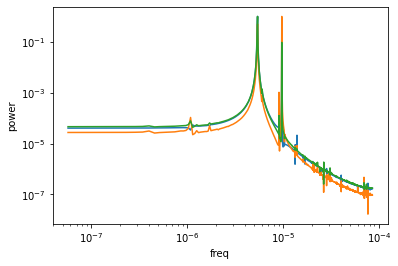

In [7]:
#powerspectra_AMD_simarch
#this function also uses a simulation archive (no integrating)
#this allows looking at the actual AMD power spectra

dt, freqs, pwr_spectra = spectral_fraction.powerspectra_AMD_simarch(simarch)

#frequencies are calculated using numpy's rfftfreq function
#this means the units are "cycles per unit of the sample spacing"
#the sample spacing is included in the output (dt)

#freqs includes 0 but the power spectra is calculated without (yes I should have fixed this but oh well)
#power spectra is normalized

plt.plot(freqs[freqs!=0],pwr_spectra)
plt.yscale('log')
plt.xscale('log')
plt.xlabel('freq')
plt.ylabel('power')